# Introduction

This notebook includes experiments on auxiliary learning. Please see the corresponding [repository](https://github.com/vivien000/auxiliary-learning)  and the associated blog post.

In [0]:
# Set to True to save the experiments' results on Google Drive
google_drive = True

In [0]:
#@title Tensorboard launch and utilities

import tarfile
import urllib.request
import json
import os
import shutil
import time
from IPython.core.display import display, HTML

get_ipython().system_raw('tensorboard --logdir ./log --host 0.0.0.0 --port 6006 &')

if os.path.exists('/content'):
  get_ipython().system_raw('wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip')
  get_ipython().system_raw('unzip -qq ngrok-stable-linux-amd64.zip')
  get_ipython().system_raw('pip install -U -q PyDrive')
  get_ipython().system_raw('./ngrok http 6006 &')
  loop = True
  while loop:
    try:
      ngrok_details = urllib.request.urlopen('http://localhost:4040/api/tunnels')
      url = json.load(ngrok_details)['tunnels'][0]['public_url']
      loop = False
    except (urllib.error.URLError, IndexError):
      time.sleep(1)
  if google_drive:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
else:
  url = 'http://0.0.0.0:6006'
display(HTML("<a href='" + url + "'>Link to Tensorboard</a>"))

def read_csv(file, *args, **kwargs):
  if google_drive:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    listed = drive.ListFile({'q': "title contains '"+file+"'"}).GetList()
    drive.CreateFile({'id': listed[0]['id']}).GetContentFile(file)
  return pd.read_csv(file, *args, **kwargs)

def append_to_log(file, line, header):
  if google_drive:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    listed = drive.ListFile({'q': "title contains '"+file+"'"}).GetList()
    if len(listed) > 0:
      file = drive.CreateFile({'id': listed[0]['id']})
      content = file.GetContentString() + line + '\n'
    else:
      file = drive.CreateFile({'title': file})
      content = header + '\n' + line + '\n'
    file.SetContentString(content)
    file.Upload()
  else:
    if os.path.isfile(file):
      with open(file, 'a') as f:  
        f.write(line)
    else:
      with open(file, 'w') as f:  
        f.write(header + '\n' + line + '\n')

def number_log_lines(file):
  if google_drive:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    listed = drive.ListFile({'q': "title contains '"+file+"'"}).GetList()
    if len(listed) > 0:
      file = drive.CreateFile({'id': listed[0]['id']})
      content = file.GetContentString()
    else:
      return 0
  else:
    if os.path.isfile(file):
      with open(file, 'a') as f:  
        content = f.read()
    else:
      return 0
  try:
      return len(content.split('\n'))-2
  except ValueError:
      return 0        

def save_folder(folders, file):
  if google_drive:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    with tarfile.open(file, 'w|gz') as tar:
      for folder in folders:
        tar.add(folder)
    listed = drive.ListFile({'q': "title contains '"+file+"'"}).GetList()
    if len(listed) > 0:
      uploaded = drive.CreateFile({'id': listed[0]['id']})
    else:
      uploaded = drive.CreateFile({'title': file})
    uploaded.SetContentFile(file)
    uploaded.Upload()
    os.remove(file)

def load_file(file):
  if google_drive:
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    listed = drive.ListFile({'q': "title contains '"+file+"'"}).GetList()
    if len(listed) > 0:
      file = drive.CreateFile({'id': listed[0]['id']})
      content = file.GetContentString()

In [0]:
import numpy as np
np.random.seed(seed=0)

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

import pandas as pd
import sklearn
import time

from IPython.display import clear_output

try:
  step_counter = tf.train.create_global_step()
except ValueError:
  step_counter.assign(0)

In [0]:
#@title CelebA dataset download
#https://gist.github.com/charlesreid1/4f3d676b33b95fce83af08e4ec261822
import requests

def download_file_from_google_drive(id, destination):
  def get_confirm_token(response):
    for key, value in response.cookies.items():
      if key.startswith('download_warning'):
        return value

    return None

  def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
      for chunk in response.iter_content(CHUNK_SIZE):
        if chunk: # filter out keep-alive new chunks
          f.write(chunk)

  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params={'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = {'id': id, 'confirm': token}
    response = session.get(URL, params = params, stream = True)

  save_response_content(response, destination)

files = {'readme.txt': '0B7EVK8r0v71pOXBhSUdJWU1MYUk',
         'celeba.zip': '0B7EVK8r0v71pZjFTYXZWM3FlRnM',
         'list_landmarks_align_celeba.txt': '0B7EVK8r0v71pd0FJY3Blby1HUTQ',
         'list_attr_celeba.txt': '0B7EVK8r0v71pblRyaVFSWGxPY0U',
         'list_eval_partition.txt': '0B7EVK8r0v71pY0NSMzRuSXJEVkk'}

for filename in files:
  download_file_from_google_drive(files[filename], filename)

commands = ['unzip -oq celeba.zip > /dev/null',
            "sed -i '1d' list_landmarks_align_celeba.txt",
            "sed -i 's/  */ /g' list_landmarks_align_celeba.txt",
            "sed -i '1d' list_attr_celeba.txt",
            "sed -i 's/  */ /g' list_attr_celeba.txt"]

for command in commands:
  get_ipython().system_raw(command)

In [0]:
attribute = 'Attractive'
iterations = 10

In [0]:
landmarks_df = pd.read_csv('list_landmarks_align_celeba.txt', sep=' ')
landmarks_df.iloc[:, 0::2] = landmarks_df.iloc[:, 0::2]/178
landmarks_df.iloc[:, 1::2] = landmarks_df.iloc[:, 1::2]/218

attributes_df = pd.read_csv('list_attr_celeba.txt', sep=' ')
attributes_df.columns = ['name'] + list(attributes_df.columns)[:-1]
attributes_df.set_index('name', inplace=True)
attributes_df = attributes_df[[attribute]]
attributes_df.replace(to_replace=-1, value=0, inplace=True)

eval_df = pd.read_csv('list_eval_partition.txt', sep=' ', names=['name', 'set'])
eval_df.set_index('name', inplace=True)

landmarks_train = landmarks_df[eval_df['set'] == 0].sample(n=10000,
                                                           random_state=0)
attributes_train = attributes_df.loc[landmarks_train.index]

landmarks_val = landmarks_df[eval_df['set'] == 1].sample(n=10000,
                                                         random_state=0)
attributes_val = attributes_df.loc[landmarks_val.index]

landmarks_test = landmarks_df[eval_df['set'] == 2].sample(n=10000,
                                                          random_state=0)
attributes_test = attributes_df.loc[landmarks_test.index]

def images(filenames):
  for filename in filenames:
    image = tf.read_file('img_align_celeba/' + filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize_bilinear(tf.expand_dims(image, 0), [40, 40])
    if image.shape[3].value == 3:
      image = tf.image.rgb_to_grayscale(image)
    try:
      result = tf.concat([result, image], axis=0)
    except NameError:
      result = image
  return tf.constant(result/255, dtype=tf.float32)

x_train = images(landmarks_train.index)
x_val = images(landmarks_val.index)
x_test = images(landmarks_test.index)

y_train = tf.constant(np.array(attributes_train), dtype=tf.float32)
y_val = tf.constant(np.array(attributes_val), dtype=tf.float32)
y_test = tf.constant(np.array(attributes_test), dtype=tf.float32)

z_train = tf.constant(np.array(landmarks_train), dtype=tf.float32)

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train, z_train))
ds_train = ds_train.shuffle(1000).batch(100)

In [0]:
class FaceModel(tf.keras.Model):
  def __init__(self):
    super(FaceModel, self).__init__()
    kwargs = {'activation': 'relu'}
    self.conv1 = tf.keras.layers.Conv2D(16, 5, **kwargs)
    self.conv2 = tf.keras.layers.Conv2D(48, 3, **kwargs)
    self.conv3 = tf.keras.layers.Conv2D(64, 3, **kwargs)
    self.conv4 = tf.keras.layers.Conv2D(64, 2, **kwargs)
    self.max = tf.keras.layers.MaxPooling2D()
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(100, **kwargs)
    self.dense2_primary = tf.keras.layers.Dense(1, activation='sigmoid')
    self.dense2_auxiliary = tf.keras.layers.Dense(len(landmarks_df.columns),
                                                  activation='sigmoid')
  
  def call(self, img):
    x = self.max(self.conv1(img))
    x = self.max(self.conv2(x))
    x = self.max(self.conv3(x))
    x = self.conv4(x)
    x = self.flatten(x)
    x = self.dense1(x)
    return self.dense2_primary(x), self.dense2_auxiliary(x)

def cross_entropy(y, y_hat):
  eps = 1e-6
  return -tf.math.reduce_mean(y*tf.math.log((1 - eps)*y_hat + eps)
                              + (1-y)*tf.math.log((1 - eps)*(1 - y_hat) + eps))

In [0]:
if not os.path.exists('initial_models'):
  os.mkdir('initial_models')
  for i in range(iterations):
    model = FaceModel()
    _ = model(x_val[:1, :, : ,:])
    model.save_weights("initial_models/model_%i.h5" % i)
  del model

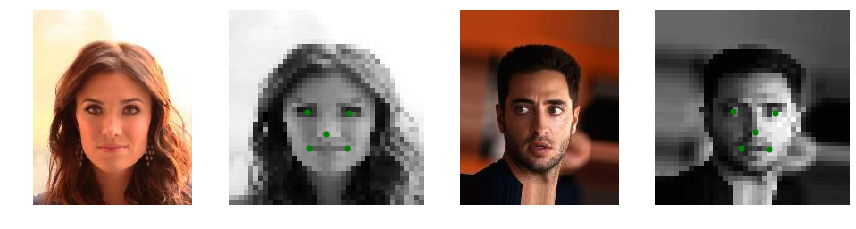

In [0]:
#@title Visualization of an example

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = 12, 4

def show(element, title=True):  
  image = element[0].numpy()
  if len(element) > 1:
    lf = element[1]
    c = element[2]
    plt.plot(lf[0::2]*40,
             lf[1::2]*40,
             marker='o',
             markerfacecolor='g',
             markeredgecolor='g',
             markersize=5,
             linestyle = 'None')
    if title:
      plt.title('%s: %s' % (attribute.replace('_', ' '),
                            {1: 'Yes', 0: 'No'}[c[0]]),
                fontdict={'weight': 'bold'})
  if len(element) > 3:
    pred = element[3]
    plt.plot(pred[0::2]*40,
         pred[1::2]*40,
         marker='o',
         markerfacecolor='r',
         linestyle = 'None')
  plt.imshow(image.reshape([40, 40]), cmap=cm.gray)


  plt.axis('off')
  plt.grid(False)

gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[178, 218, 178, 218]) 
i = 20
ax0 = plt.subplot(gs[0])
filename = landmarks_train.index[i]
image = tf.read_file('img_align_celeba/' + filename)
image = tf.image.decode_jpeg(image)
ax0.imshow(image)
ax0.axis('off')
ax0.grid(False)

ax1 = plt.subplot(gs[1])
image = x_train[i, :, : , :]
lf = np.array(landmarks_train)[i, :]
c = np.array(attributes_train)[i, :]
show((image, lf, c), title=False)

i = 105
ax0 = plt.subplot(gs[2])
filename = landmarks_train.index[i]
image = tf.read_file('img_align_celeba/' + filename)
image = tf.image.decode_jpeg(image)
ax0.imshow(image)
ax0.axis('off')
ax0.grid(False)

ax1 = plt.subplot(gs[3])
image = x_train[i, :, : , :]
lf = np.array(landmarks_train)[i, :]
c = np.array(attributes_train)[i, :]
show((image, lf, c), title=False)

plt.tight_layout()
plt.savefig('faces.png', bbox_inches='tight')

In [0]:
def censored_vector(u, v, mode):
  """Adjusts the auxiliary loss gradient
  
  Adjusts the auxiliary loss gradient before adding it to the primary loss
  gradient and using a gradient descent-based method
  
  Args:
    u: A tensorflow variable representing the auxiliary loss gradient
    v: A tensorflow variable representing the primary loss gradient
    mode: The method used for the adjustment:
      - Single task: the auxiliary loss gradient is ignored
      - Multitask: the auxiliary loss gradient is kept as it is
      - Unweighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Weighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Projection: cf. https://github.com/vivien000/auxiliary-learning
      - Parameter-wise: same as projection but at the level of each parameter
    
  Returns:
    A tensorflow variable representing the adjusted auxiliary loss gradient
  """
  if mode == 'Single task' or u is None:
    return 0  
  if mode == 'Multitask' or v is None:
    return u
  if len(u.shape.as_list()) == 1:
    u_dot_v, l_u, l_v = tf.reduce_sum(u*v), tf.norm(u), tf.norm(v)
  else:
    a, b = tf.reshape(u, [-1]), tf.reshape(v, [-1])
    u_dot_v, l_u, l_v = tf.reduce_sum(a*b), tf.norm(a), tf.norm(b)
  if l_u.numpy() == 0 or l_v.numpy() == 0:
    return u
  if mode == 'Unweighted cosine':
    return u if u_dot_v > 0 else tf.zeros_like(u)
  if mode == 'Weighted cosine':
    return tf.maximum(u_dot_v, 0)*u/l_u/l_v
  if mode == 'Projection':
    return u - tf.minimum(u_dot_v, 0)*v/l_v/l_v
  if mode == 'Parameter-wise':
    return u*((tf.math.sign(u*v)+1)/2)

def combined_grads(primary_grad,
                   average_primary_grad,
                   auxiliary_grad,
                   mode,
                   overall=False,
                   lam=1):
  """Combines auxiliary loss gradients and primary loss gradients
  
  Combines a sequence of auxiliary loss gradients and a sequence of primary
  loss gradients before performing a gradient descent step
  
  Args:
    primary_grad: A list of tensorflow variables corresponding to the primary
    loss gradient for the network's Keras variables
    average_primary_grad: A list of tensorflow variables corresponding to
    exponential moving averages of the elements above
    auxiliary_grad: A list of tensorflow variables corresponding to the
    auxiliary loss gradient for the network's Keras variables
    mode: The method used for the adjustment:
      - Single task: the auxiliary loss gradient is ignored
      - Multitask: the auxiliary loss gradient is kept as it is
      - Unweighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Weighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Projection: cf. https://github.com/vivien000/auxiliary-learning
      - Parameter-wise: same as projection but at the level of each parameter
    overall: True if the transformation takes place at the level of the whole
    parameter vector, i.e. the concatenation of all the Keras variables of the
    network
    lambda: Float balancing the primary loss and the auxiliary loss
    
  Returns:
    A list of tensorflow variables combining the primary loss gradients and the
    auxiliary loss gradients and that can directly be used for the next gradient
    descent step
  """
  result = [0]*len(primary_grad)
  a = tf.constant([], dtype=tf.float32)
  aa = tf.constant([], dtype=tf.float32)
  b = tf.constant([], dtype=tf.float32)
  shapes = []
  for i in range(len(primary_grad)):
    if auxiliary_grad[i] is None or mode == 'Single task':
      result[i] = primary_grad[i]
    elif primary_grad[i] is None:
      result[i] = lam*auxiliary_grad[i]
    elif mode == 'Multitask':
      result[i] = primary_grad[i] + lam*auxiliary_grad[i]
    elif not overall:
      if average_primary_grad is None:
        result[i] = (primary_grad[i]
                     + lam*censored_vector(auxiliary_grad[i],
                                           primary_grad[i],
                                           mode))
      else:
        result[i] = (primary_grad[i]
                     + lam*censored_vector(auxiliary_grad[i],
                                           average_primary_grad[i],
                                           mode))
    else:
      a = tf.concat([a, tf.reshape(primary_grad[i], [-1])], axis=0)
      if average_primary_grad is not None:
        aa = tf.concat([aa, tf.reshape(average_primary_grad[i], [-1])], axis=0)
      b = tf.concat([b, tf.reshape(auxiliary_grad[i], [-1])], axis=0)
      shapes.append((primary_grad[i].shape,
                     np.product(primary_grad[i].shape.as_list()),
                     i))

  if len(shapes) > 0:
    if average_primary_grad is None:
      c = a + lam*censored_vector(b, a, mode)
    else:
      c = a + lam*censored_vector(b, aa, mode)
    start = 0
    for i in range(len(shapes)):
      shape, length, index = shapes[i]
      result[index] = tf.reshape(c[start:start+length], shape)
      start += length
  return result

def train_iteration(model,
                    average_primary_grad,
                    alpha,
                    optimizer,
                    writer,
                    step_counter,
                    mode,
                    overall=False,
                    lam=1):
  with writer.as_default(), tf.contrib.summary.always_record_summaries():
    for x, y, z in ds_train.make_one_shot_iterator():
      with tf.GradientTape(persistent=True) as tape:
        y_hat, z_hat = model(x)
        primary_loss = cross_entropy(y, y_hat)
        if mode != 'Single task':
          auxiliary_loss = tf.reduce_mean((z_hat-z)**2)
      tf.contrib.summary.scalar('primary_loss', primary_loss)
     
      primary_grad = tape.gradient(primary_loss, model.variables)
      if mode == 'Single task':
        optimizer.apply_gradients(zip(primary_grad, model.variables),
                                  global_step=step_counter)
      else:
        tf.contrib.summary.scalar('auxiliary_loss', auxiliary_loss)
        auxiliary_grad = tape.gradient(auxiliary_loss, model.variables)
        
        if alpha != 1:
          if average_primary_grad is None:
            average_primary_grad = primary_grad
          else:
            for i in range(len(average_primary_grad)):
              if primary_grad[i] is not None:
                average_primary_grad[i] = ((1 - alpha)*average_primary_grad[i]
                                           + alpha*primary_grad[i])        
        
        grad = combined_grads(primary_grad,
                              average_primary_grad,
                              auxiliary_grad,
                              mode,
                              overall=overall,
                              lam=lam)
        optimizer.apply_gradients(zip(grad, model.variables),
                                  global_step=step_counter)
  return average_primary_grad

def get_metrics(dataset,
                model,
                writer,
                step_counter):
  x, y = (x_val, y_val) if dataset == 'val' else (x_test, y_test)
  with writer.as_default(), tf.contrib.summary.always_record_summaries():
    y_hat = model(x)[0]
    primary_loss = cross_entropy(y, y_hat)
    tf.contrib.summary.scalar('primary_loss', primary_loss)
    acc = sklearn.metrics.accuracy_score(y.numpy(), y_hat.numpy()>0.5)
    tf.contrib.summary.scalar('accuracy', acc)
    fpr, tpr, _ = sklearn.metrics.roc_curve(y.numpy(), y_hat.numpy())
    auc = sklearn.metrics.auc(fpr, tpr)
    tf.contrib.summary.scalar('AUC', auc)
  return primary_loss.numpy(), acc, auc

In [0]:
def run_experiment(name, model, alpha, mode, overall, lam, output):
  train_writer = tf.contrib.summary.create_file_writer('./log/train/' + name,
                                                       flush_millis=10000)
  val_writer = tf.contrib.summary.create_file_writer('./log/val/' + name,
                                                       flush_millis=10000)
  test_writer = tf.contrib.summary.create_file_writer('./log/test/' + name,
                                                      flush_millis=10000)
  step_counter.assign(0)
  optimizer = tf.train.AdamOptimizer()
  checkpoint_dir = 'model_celeba'
  shutil.rmtree(checkpoint_dir, ignore_errors=True)
  checkpoint_prefix = os.path.join(checkpoint_dir, 'model.ckpt')
  root = tf.contrib.eager.Checkpoint(optimizer=optimizer,
                                     model=model,
                                     optimizer_step=step_counter)
  
  average_primary_grad = None
  iteration, not_better, best_auc = 1, 0, 0
  while not_better < 10:
    average_primary_grad = train_iteration(model,
                                           average_primary_grad,
                                           alpha,
                                           optimizer,
                                           train_writer,
                                           step_counter,
                                           mode,
                                           overall=overall,
                                           lam=lam)
    val_loss, val_acc, val_auc = get_metrics('val',
                                             model,
                                             val_writer,
                                             step_counter)
    clear_output()
    print(output)
    print(iteration, val_loss, val_acc, val_auc)
    if val_auc > best_auc:
      not_better, best_auc = 0, val_auc
      root.save(file_prefix=checkpoint_prefix)
    else:
      not_better += 1
    iteration += 1

  root.restore(tf.train.latest_checkpoint(checkpoint_dir))
  return model, get_metrics('test', model, test_writer, step_counter)

In [0]:
def run_experiments(configs, filename):
  already_done = number_log_lines(filename)

  runs_list = []
  header = 'mode,overall,alpha,lam,test_loss,test_acc,test_auc'
  output = ''

  current_iteration = -1

  for iteration, mode, overall, lam, alpha in configs[already_done:]:

    start = time.time()

    model = FaceModel()
    _ = model(x_val[:1, :, : ,:])
    model.load_weights("initial_models/model_%i.h5" % iteration)

    output += 'Iteration #%d: %s (overall: %s, %d)\n' % (iteration,
                                                          mode,
                                                          overall,
                                                          lam)
    name = '%s-%s-%s-%d-%f' % (iteration, mode, overall, lam, alpha)
    test_loss, test_acc, test_auc = run_experiment(name,
                                                   model,
                                                   alpha,
                                                   mode,
                                                   overall,
                                                   lam,
                                                   output)[1]
    template = 'Loss: %.3f, accuracy: %.1f%%, AUC: %.3f (%d seconds)\n\n'
    output += template % (test_loss, test_acc*100, test_auc, time.time()-start)
    dict1 = {'mode': mode,
             'lam': lam,
             'overall': overall,
             'alpha': alpha,
             'test_loss': test_loss,
             'test_acc': test_acc,
             'test_auc': test_auc}
    runs_list.append(dict1)
    line = "%s,%s,%f,%d,%f,%f,%f" % (mode,
                                     overall,
                                     alpha,
                                     lam,
                                     test_loss,
                                     test_acc,
                                     test_auc)
    append_to_log(filename, line, header)

  return pd.DataFrame(runs_list)

In [0]:
configs = [('Single task', True, 0, 1)]

configs += [(mode, True, lam, 1)
           for lam in [300, 1000, 3000, 10000, 30000]
           for mode in ['Multitask']]

configs += [(mode, True, lam, 1)
           for lam in [300, 1000, 3000, 10000, 30000]
           for mode in ['Projection', 'Unweighted cosine', 'Weighted cosine']]

configs += [(mode, False, lam, 1)
           for lam in [300, 1000, 3000, 10000, 30000]
           for mode in ['Projection', 'Parameter-wise']]

configs += [(mode, True, lam, alpha)
           for lam in [300, 1000, 3000, 10000, 30000]
           for mode in ['Projection']
           for alpha in [0.01, 0.1]]

configs = [(iteration, mode, overall, lam, alpha)
           for iteration in range(iterations)
           for mode, overall, lam, alpha in configs]

filename = 'real_dataset_experiments.csv'

_ = run_experiments(configs, filename)